In [6]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [7]:
import plotly.express as px

In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [9]:
df = pd.read_csv('Zemlya.csv', index_col=0)
df['x'].fillna(df['x'].mean(), inplace=True)
df

,x
1,-143
2,-114
3,4609
4,7309
5,3372
...,...
3044,-2335
3045,-2665
3046,1721
3047,5358


In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [11]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [12]:
len(list_for_forecast)

3047

In [13]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [14]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [16]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  3910.913295559079


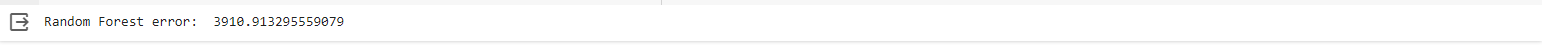

In [17]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 4943.030840851276
MAPE: 3.0952586376605082
MAE: 3910.913295559079
R2:  0.7598542238484449


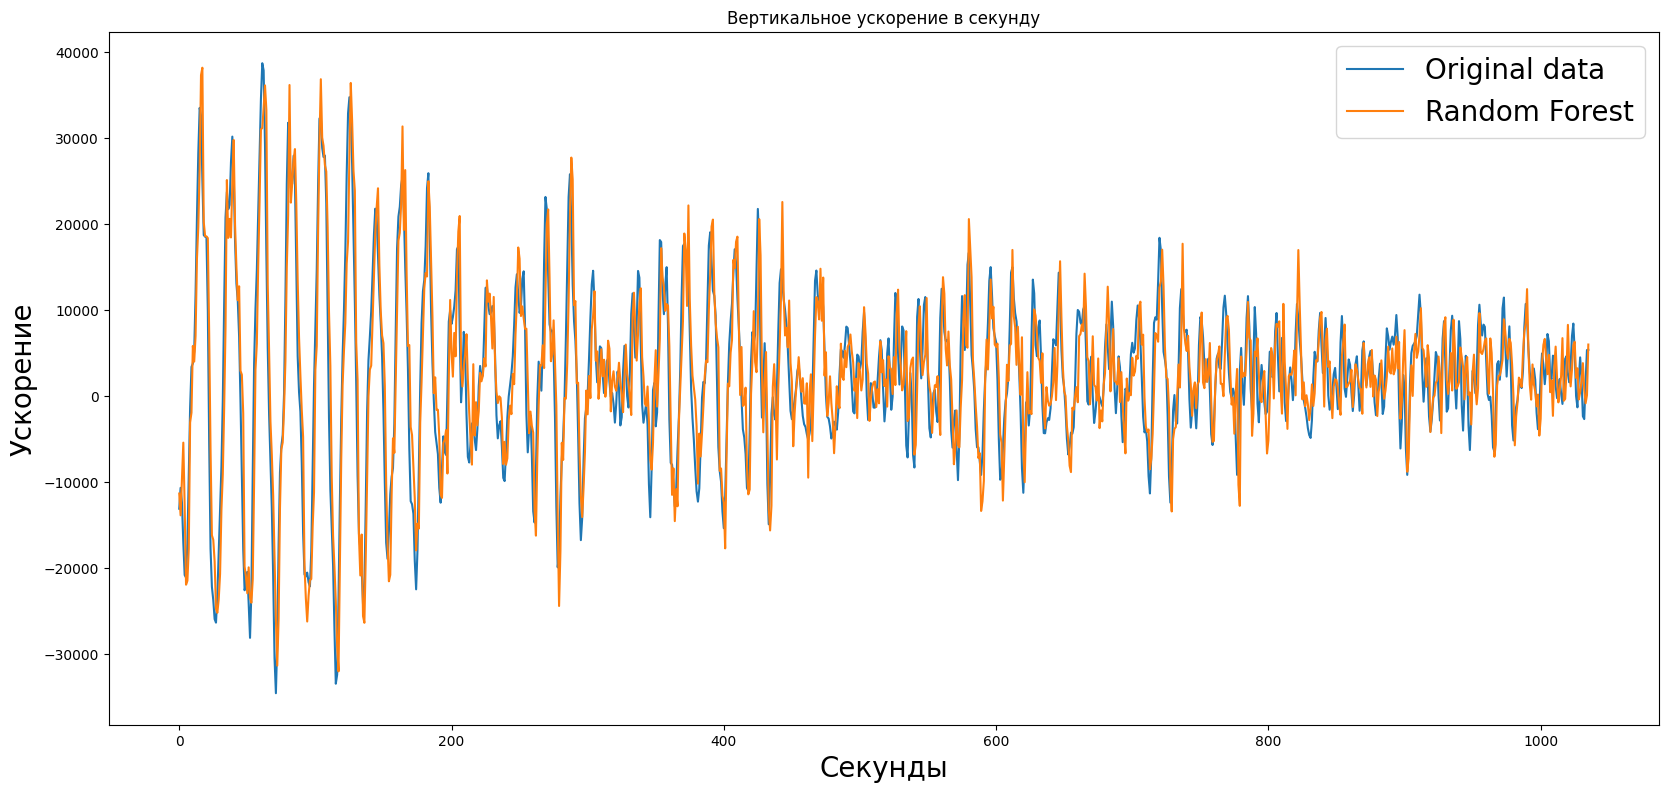

In [18]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Random Forest')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение в секунду')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()

In [19]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

In [20]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 5696.321976859728
MAPE: 3.4063553792294097
MAE: 4509.671975546975
R2:  0.6810832199800332


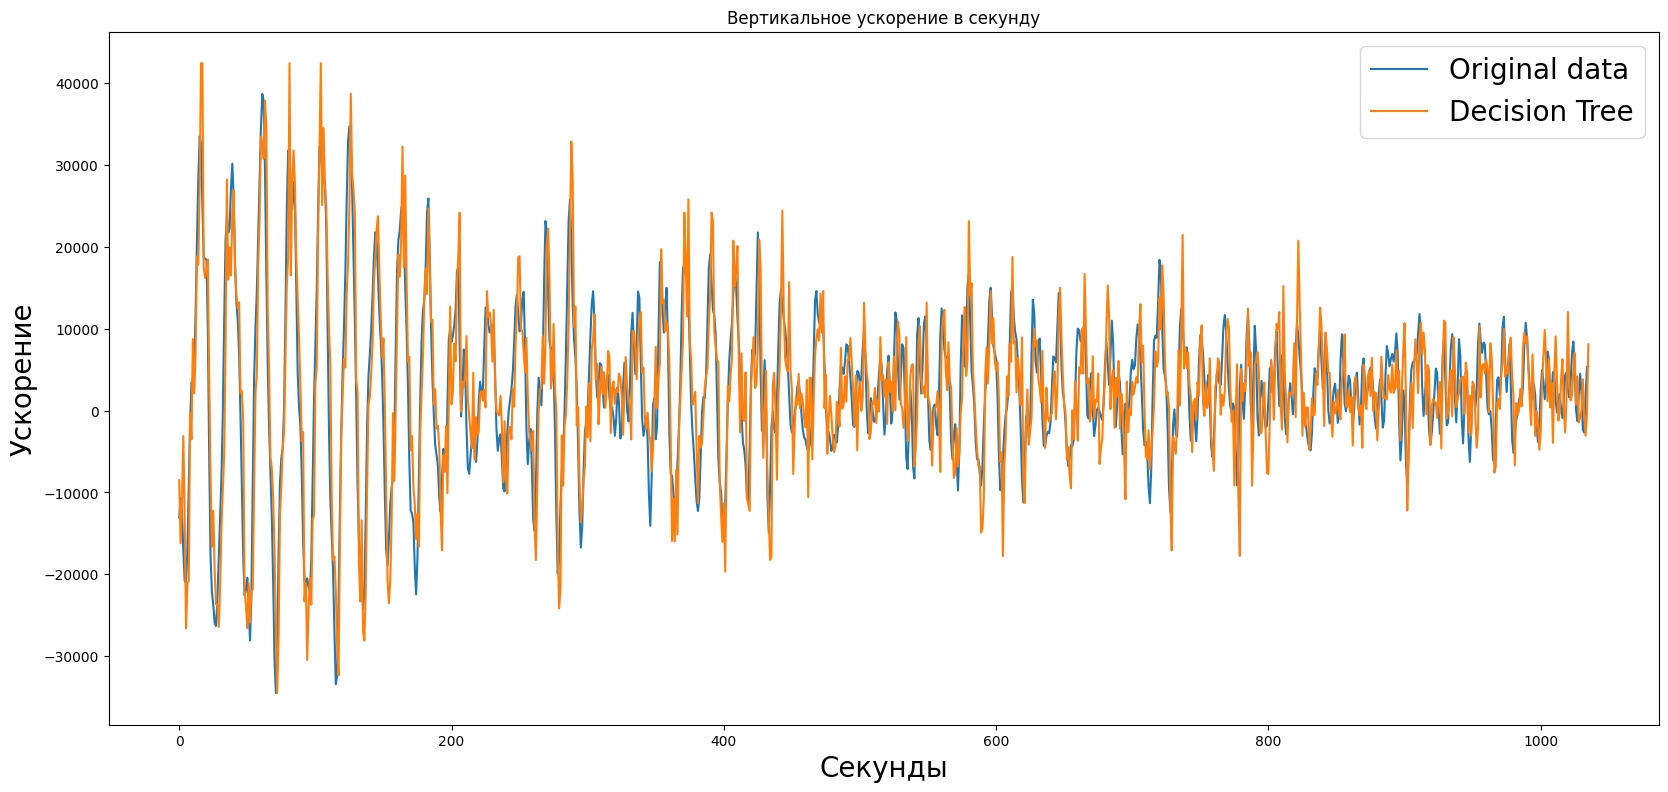

In [21]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Вертикальное ускорение в секунду')
plt.ylabel('Ускорение', fontsize="20")
plt.xlabel('Секунды', fontsize="20")
plt.show()

In [22]:
from sklearn.ensemble import IsolationForest

In [29]:
df = pd.read_csv('Zemlya.csv')
df['x'].fillna(df['x'].mean(), inplace=True)
df.set_index('x').sort_index()

,Unnamed: 0
x,
-34522,2084
-33417,2128
-32356,2129
-30459,2083
-28860,1882
...,...
34741,2138
37853,2075
38691,2074


In [31]:
model = IsolationForest(contamination=0.004)
model.fit(df[['x']])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.004)

In [32]:
df['outliers'] = pd.Series(model.predict(df[['x']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [33]:
df.query('outliers=="yes"')

,Unnamed: 0,x,outliers
1868,1869,42428,yes
1869,1870,39731,yes
2027,2028,33499,yes
2072,2073,34505,yes
2073,2074,38691,yes
2074,2075,37853,yes
2083,2084,-34522,yes
2127,2128,-33417,yes
2128,2129,-32356,yes
2136,2137,32870,yes


In [34]:
fig = px.scatter(df.reset_index(), y='x', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()